# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Transferência-de-estilos-em-imagens" data-toc-modified-id="Transferência-de-estilos-em-imagens-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transferência de estilos em imagens</a></div><div class="lev2 toc-item"><a href="#Conteúdo-e-estilo" data-toc-modified-id="Conteúdo-e-estilo-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conteúdo e estilo</a></div><div class="lev3 toc-item"><a href="#Representações-de-imagens-em-redes-neurais-convolucionais" data-toc-modified-id="Representações-de-imagens-em-redes-neurais-convolucionais-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Representações de imagens em redes neurais convolucionais</a></div><div class="lev2 toc-item"><a href="#Reconstrução-da-imagem-de-conteúdo" data-toc-modified-id="Reconstrução-da-imagem-de-conteúdo-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Reconstrução da imagem de conteúdo</a></div><div class="lev3 toc-item"><a href="#Esquema-para-reconstrução-da-imagem-a-partir-de-uma-camada-da-rede" data-toc-modified-id="Esquema-para-reconstrução-da-imagem-a-partir-de-uma-camada-da-rede-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Esquema para reconstrução da imagem a partir de uma camada da rede</a></div><div class="lev3 toc-item"><a href="#Otimizadores-avançados" data-toc-modified-id="Otimizadores-avançados-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Otimizadores avançados</a></div><div class="lev2 toc-item"><a href="#Experimento" data-toc-modified-id="Experimento-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Experimento</a></div><div class="lev3 toc-item"><a href="#Imagens-e-processamento-inicial" data-toc-modified-id="Imagens-e-processamento-inicial-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Imagens e processamento inicial</a></div><div class="lev3 toc-item"><a href="#Rede-VGG19" data-toc-modified-id="Rede-VGG19-132"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Rede VGG19</a></div><div class="lev3 toc-item"><a href="#Função-de-custo-para-a-otimização" data-toc-modified-id="Função-de-custo-para-a-otimização-133"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Função de custo para a otimização</a></div><div class="lev3 toc-item"><a href="#Funções-auxiliares" data-toc-modified-id="Funções-auxiliares-134"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Funções auxiliares</a></div><div class="lev3 toc-item"><a href="#Criando-o-grafo-de-processamento" data-toc-modified-id="Criando-o-grafo-de-processamento-135"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>Criando o grafo de processamento</a></div><div class="lev3 toc-item"><a href="#Obtendo-a-imagem:-entrada-aleatória" data-toc-modified-id="Obtendo-a-imagem:-entrada-aleatória-136"><span class="toc-item-num">1.3.6&nbsp;&nbsp;</span>Obtendo a imagem: entrada aleatória</a></div><div class="lev3 toc-item"><a href="#Obtendo-a-imagem:-entrada-zerada" data-toc-modified-id="Obtendo-a-imagem:-entrada-zerada-137"><span class="toc-item-num">1.3.7&nbsp;&nbsp;</span>Obtendo a imagem: entrada zerada</a></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg19

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage.filters import gaussian_filter

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


# Transferência de estilos em imagens

## Conteúdo e estilo

Este é o primeiro de uma sequência de três *notebooks* que preparamos para apresentar o tema "transferência de estilos entre imagens". O problema é similar ao de transferir texturas entre imagens, onde uma imagem original é texturizada com base em outra imagem. 

Dada uma imagem de "conteúdo", normalmente uma imagem real ou foto, e outra imagem de "estilo", uma pintura, por exemplo, misturamos as duas de forma que a imagem resultante possa ser considerada como aquele conteúdo representado no estilo da segunda imagem.

O problema é ilustrado na figura seguinte.

### Representações de imagens em redes neurais convolucionais

<table align='left'>
<tr><td> <img src="https://drive.google.com/uc?id=0By1KMDFVxsI2UlFPQ1R4S3poMWc"> </td></tr>
</table>

## Reconstrução da imagem de conteúdo

### Esquema para reconstrução da imagem a partir de uma camada da rede

A imagem seguinte ilustra o processo de obtenção da imagem representada pelos mapas de features de uma camada da rede VGG.

<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1wlmVcKYfRjH6mxFdODXsZkbyJEsNX1E2umRzZkxOsM0/pub?w=960&h=720"> </td></tr>
</table>


### Otimizadores avançados

## Experimento

### Imagens e processamento inicial

In [3]:
resdir = './style_results/'
os.makedirs(resdir, exist_ok=True)

image_file_path = '../../datasets/images/museu_by_bruna.png'
style_file_path = '../../datasets/images/van_gogh_3.jpg'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

print('Shape of the images: {} rows, {} columns'.format(img_nrows, img_ncols))

Shape of the images: 400 rows, 499 columns


Shape, min, max (1, 400, 499, 3) -123.68 151.061


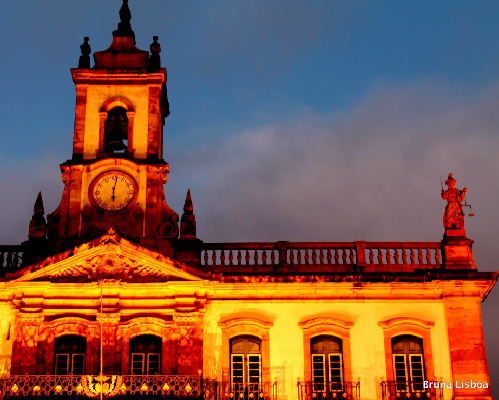

In [4]:
vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print('Shape, min, max:', vgg_image.shape, vgg_image.min(), vgg_image.max())

array_to_img(deprocess_image(vgg_image[0]))

### Rede VGG19

In [5]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 499, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 499, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 499, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 249, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 249, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 249, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 124, 128)     0         
__________

### Função de custo para a otimização

In [6]:
def compute_content_loss(base, output):
    """
    Feature reconstruction loss function. Encourages the 
    output img to be perceptually similar to the base image.
    """
    return K.sum(K.square(output - base))

### Funções auxiliares

In [7]:
class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        self.loss, self.grad_values = self.funct([x.reshape(self.shape)])
        return self.loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

def my_solver(obj, x, niter=10, prefix=None, interval=1):
    images = []
    try:
        for i in range(niter):
            t0 = time.time()
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            dt = time.time() - t0
            if i%interval == 0:
                print('{:2d}. loss: {:.3e} {:.3f}s'.format(i, min_val, dt))
                if prefix is not None:
                    imsave(resdir + prefix + '_at_iteration_{:02d}.png'.format(i), deprocess_image(x))
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    finally:
        return images  

### Criando o grafo de processamento

<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/10jG1KHWr276i32Pa1Bt_8z3bUowX9mSm6ACA6hVnzxM/pub?w=831&h=635"> </td></tr>
</table>


In [8]:
vgg_output_dict = {layer.name: layer.output for layer in vgg.layers}

In [9]:
content_output = vgg_output_dict['block5_conv1']
content_model = Model(vgg.input, content_output)
content_target = K.variable(content_model.predict(vgg_image))
content_loss = compute_content_loss(content_output, content_target)

In [10]:
grads = K.gradients(content_loss, vgg.input)
fn = K.function([vgg.input], [content_loss] + grads)

### Obtendo a imagem: entrada aleatória

 0. loss: 2.462e+09 6.203s
10. loss: 2.767e+08 5.632s
20. loss: 1.767e+08 5.683s
30. loss: 1.373e+08 5.729s
40. loss: 1.145e+08 5.717s
50. loss: 9.823e+07 5.782s


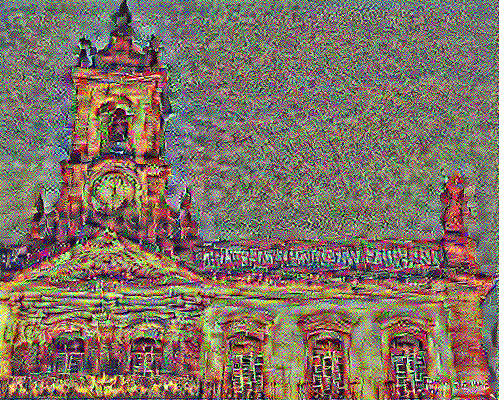

In [11]:
x = np.random.uniform(0.0, 255.0, vgg_image.shape) - 128.0
A = my_solver(Evaluator(fn, vgg_image.shape), x, niter=51, interval=10)

array_to_img(deprocess_image(A[-1]))

### Obtendo a imagem: entrada zerada

 0. loss: 3.377e+09 5.683s
10. loss: 2.192e+08 5.721s
20. loss: 1.297e+08 5.778s
30. loss: 9.880e+07 5.749s
40. loss: 8.261e+07 5.743s
50. loss: 7.166e+07 5.774s


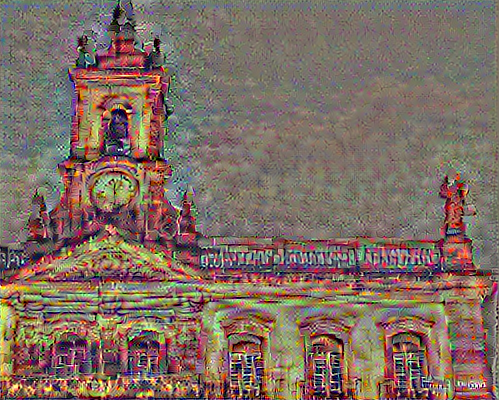

In [12]:
x = np.zeros(vgg_image.shape, np.float)
A = my_solver(Evaluator(fn, vgg_image.shape), x, niter=51, interval=10)

array_to_img(deprocess_image(A[-1]))